In [1]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import solve_ivp


In [2]:
# declaring values
LENGTH = 5                          # in m
BREADTH = 0.5                       # in m
HEIGHT = 0.5                        # in m
MOD_ELAS = 7E10                     # modulus of elasticity in N/m^4
DENSITY = 2700                      # in Kg/m^3
    
AREA = BREADTH*HEIGHT               # in m^2
AREA_MI = (BREADTH*(HEIGHT**3))/12    # area moment of inertia in m^4
N = 10

In [3]:
def make_csv(data, name):
    df = pd.DataFrame(data)
    name += '.csv'  
    df.to_csv(name, index = None, header = None)

def make_mass_matrix(n):
    M = np.zeros((n, n), dtype = 'float')
    M[0][0] = 1
    M[0][1] = 0.5
    M[1][0] = 0.5
    M[0][2] = 1/3
    M[1][1] = 1/3
    M[2][0] = 1/3
    M[1][2] = 0.25
    M[2][1] = 0.25
    M[2][2] = 0.2
    for x in range(3, n):
        M[1][x] = (np.cos((x - 2)*np.pi) - 1)/(((x - 2)**2)*np.pi**2)
        M[x][1] = (np.cos((x - 2)*np.pi) - 1)/(((x - 2)**2)*np.pi**2)
        M[2][x] = 2*np.cos((x - 2)*np.pi)/(((x - 2)**2)*np.pi**2)
        M[x][2] = 2*np.cos((x - 2)*np.pi)/(((x - 2)**2)*np.pi**2)
        M[x][x] = 0.5
    return M


def make_stiffness_matrix(n):
    K = np.zeros((n,n), dtype = 'float')
    K[2][2] = 4

    for x in range(3, n):
        K[x][x] = 0.5*(np.pi**4)*(x - 2)**4

    return K


def make_translational_constraint_x_0(n):
    translational_constraint_x_0 = np.ones((n,n))
    translational_constraint_x_0[:, 1:3] =  0
    translational_constraint_x_0[1:3, :] =  0
    return translational_constraint_x_0


def make_rotational_constraint_x_0(n):
    rotational_constraint_x_0 = np.zeros((n,n))
    rotational_constraint_x_0[1][1] = 1
    return rotational_constraint_x_0


def make_translational_constraint_x_L(n):
    translational_constraint_x_L = np.ones((n, n), dtype = 'int')
    for x in range(3, n):
        translational_constraint_x_L[0][x] = np.cos((x - 2)*np.pi)
        translational_constraint_x_L[x][0] = np.cos((x - 2)*np.pi)
        translational_constraint_x_L[1][x] = np.cos((x - 2)*np.pi)
        translational_constraint_x_L[x][1] = np.cos((x - 2)*np.pi)
        translational_constraint_x_L[2][x] = np.cos((x - 2)*np.pi)
        translational_constraint_x_L[x][2] = np.cos((x - 2)*np.pi)
    for x in range(3, n):
        for y in range(3, n):
            translational_constraint_x_L[x][y] = np.cos((x - 2)*np.pi)*np.cos((y - 2)*np.pi)
    return translational_constraint_x_L


def make_rotational_constraint_x_L(n):
    rotational_constraint_x_L = np.zeros((n,n))
    rotational_constraint_x_L[1][1] = 1
    rotational_constraint_x_L[1][2] = 2
    rotational_constraint_x_L[2][1] = 2
    rotational_constraint_x_L[2][2] = 4
    return rotational_constraint_x_L



def make_penalty_matrix(t_c_0, r_c_0, t_c_L, r_c_L, k_0, k_r_0, k_L, k_r_L):
    n = len(t_c_0)
    penality_matrix = np.zeros((n,n))
    for x in range(n):
        for y in range(n):
            penality_matrix[x][y] = k_0*t_c_0[x][y] + k_r_0*r_c_0[x][y] + k_L*t_c_L[x][y] + k_r_L*r_c_L[x][y]
    
    return penality_matrix

In [4]:
K_Coeff = MOD_ELAS*AREA_MI/LENGTH**3
M_Coeff = DENSITY*AREA*LENGTH

# Modeshapes and Convergence of Fixed - Free beam

In [5]:
# Fixed Free
N = 10

# non dimensionalised stiffness matrix
K_MATRIX = make_stiffness_matrix(N)
# make_csv(K_MATRIX, 'K')

# non dimensionalised mass matrix
M_MATRIX = make_mass_matrix(N)
# make_csv(M_MATRIX, 'M')

cM = 0       # Inertial Penalty Parameter
cK = 1       # Stiffness type Penalty Parameter


PenaltyParameter = 1000000
K0 = PenaltyParameter * 1     # Translation at x = 0
KR0 = PenaltyParameter * 1    # Rotation at x = 0
KL = PenaltyParameter * 0     # Translation at x = L
KRL = PenaltyParameter * 0    # Rotation at x = L

TRANSLATIONAL_CONSTRAINT_0 = make_translational_constraint_x_0(N)
# make_csv(TRANSLATIONAL_CONSTRAINT_0, "T_C_0")

ROTATIONAL_CONSTRAINT_0 = make_rotational_constraint_x_0(N)
# make_csv(ROTATIONAL_CONSTRAINT_0, "R_C_0")

TRANSLATIONAL_CONSTRAINT_L = make_translational_constraint_x_L(N)
# make_csv(TRANSLATIONAL_CONSTRAINT_L, "T_C_L")

ROTATIONAL_CONSTRAINT_L = make_rotational_constraint_x_L(N)
# make_csv(ROTATIONAL_CONSTRAINT_L, "R_C_L")



# fnding the penalty matrix of the beam
PENALTY_MATRIX = make_penalty_matrix(TRANSLATIONAL_CONSTRAINT_0, ROTATIONAL_CONSTRAINT_0, TRANSLATIONAL_CONSTRAINT_L,  ROTATIONAL_CONSTRAINT_L, K0, KR0, KL, KRL)
# make_csv(PENALTY_MATRIX, "P_M")

K = K_Coeff*(K_MATRIX + cK * PENALTY_MATRIX)
M = M_Coeff*(M_MATRIX + cM * PENALTY_MATRIX)


C = np.zeros((N, N))
print(C.shape)
print(np.linalg.inv(M).shape)
A = np.vstack([
    np.hstack([
        np.zeros((N, N)), 
        np.eye(N, N)]), 
    np.hstack([
        -np.matmul(np.linalg.inv(M), K), 
        -np.matmul(np.linalg.inv(M), C)])])
B = np.vstack([np.zeros((N, N)), np.linalg.inv(M)])


(10, 10)
(10, 10)


In [6]:

def F(t, y):

    Functions = np.zeros((N, 1))

########################################################################################################################################################################################
    Functions[-1] = np.cos(16.5*2*np.pi*t)
########################################################################################################################################################################################

    yvec = np.array([[y[i] for i in range(2*N)]]).T

    ydot = np.matmul(A, yvec) + np.matmul(B, Functions)

    return ydot

#######################################################################################################################################################################################
start_time = 0
end_time = 1
delta_t = 0.01
initial_conditions = np.zeros(2*N)
#######################################################################################################################################################################################

TE = np.arange(start_time, end_time, delta_t)

time_interval = np.array([start_time, end_time])

sol = solve_ivp(F, time_interval, initial_conditions, t_eval = TE, vectorized=True)

T = sol.t
Y = sol.y

print(len(Y), len(Y[0]))
make_csv(Y, 'y_25-elems_0to3-time_0.01-timestep_2cos175t-forcing_rrm')
make_csv(T, 't_25-elems_0to3-time_0.01-timestep_2cos175t-forcing_rrm')


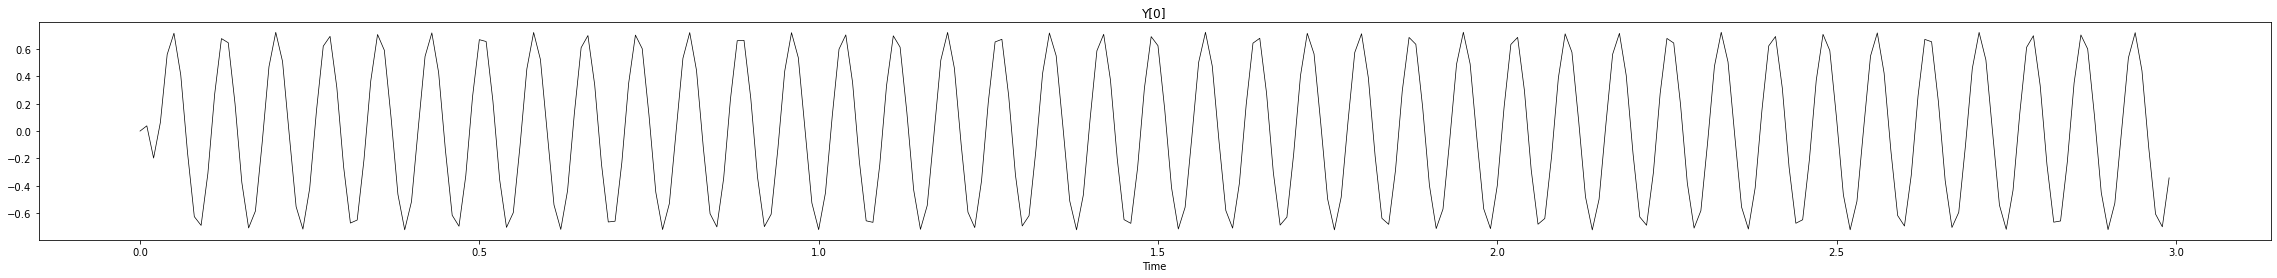

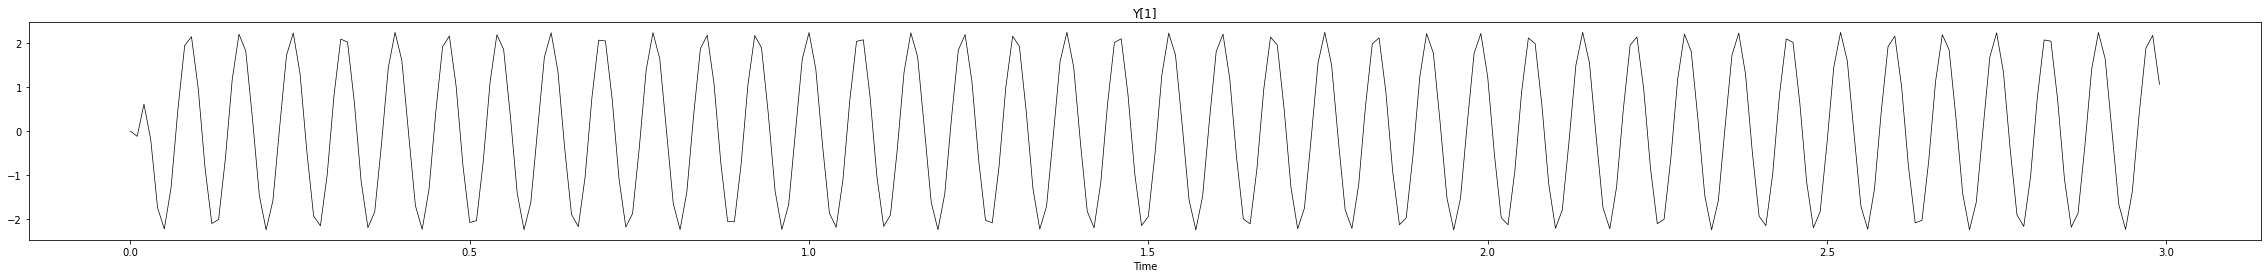

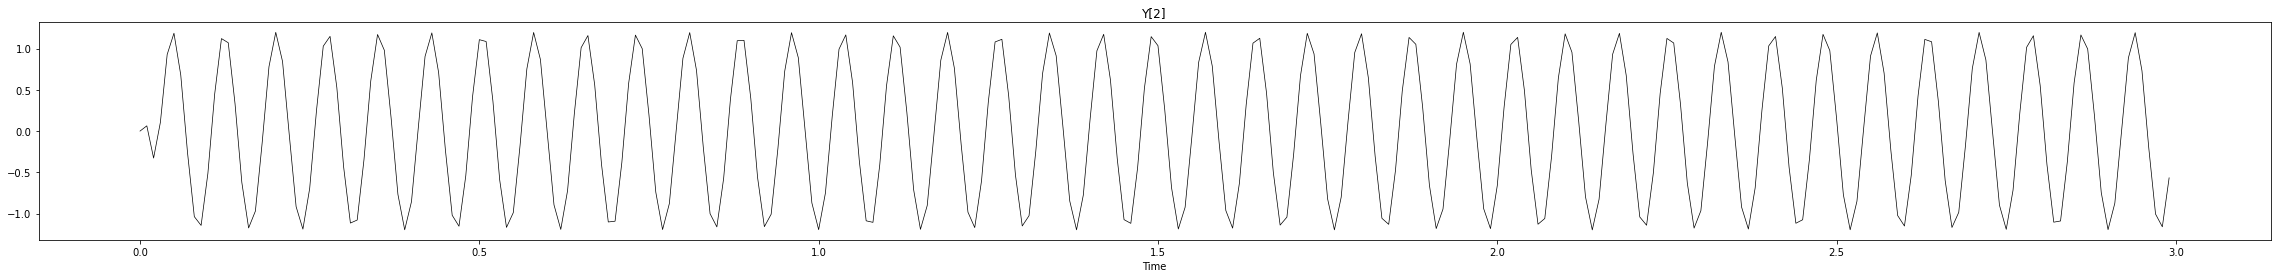

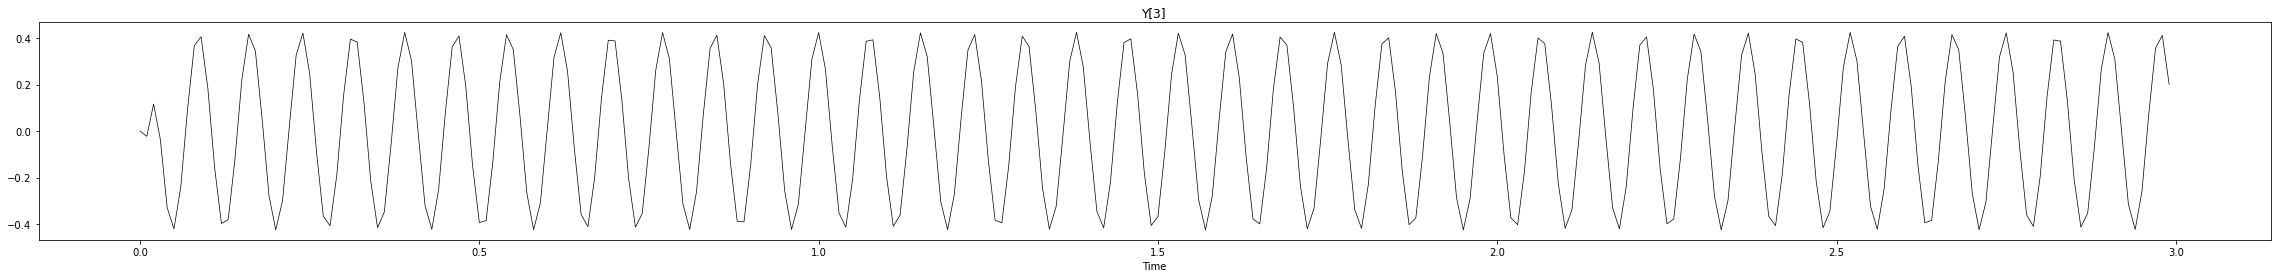

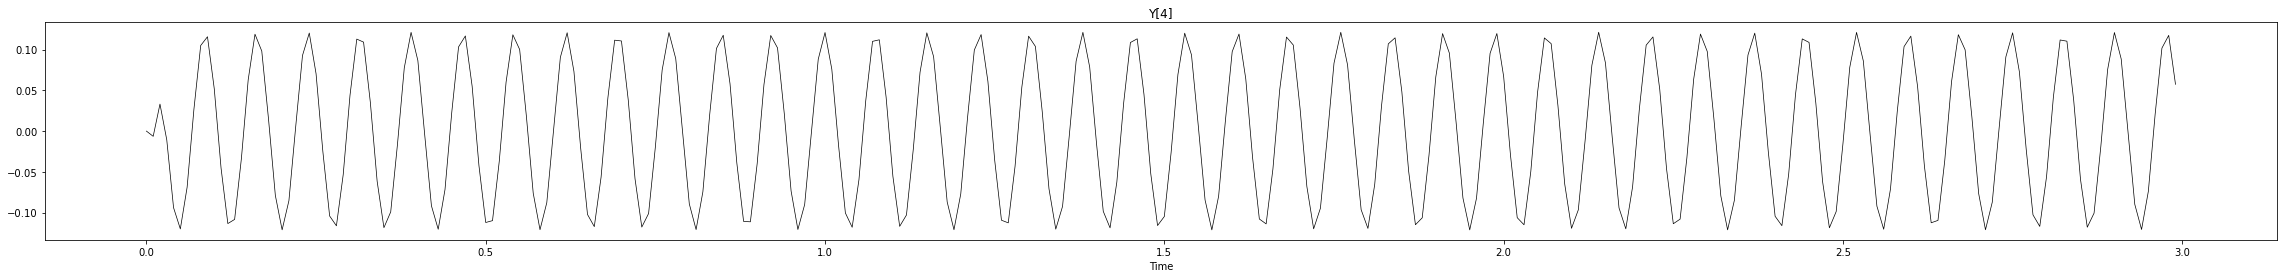

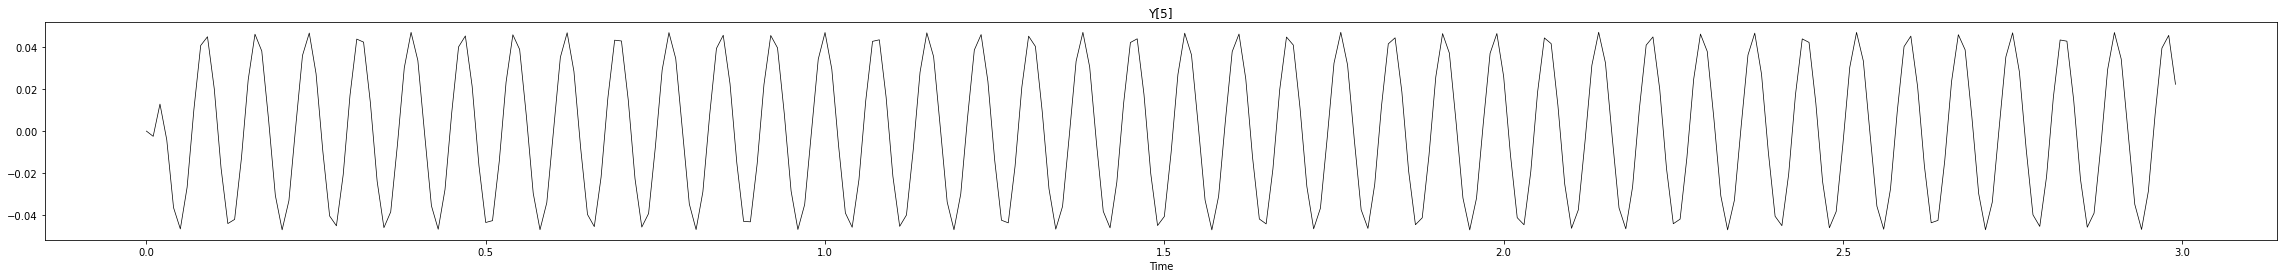

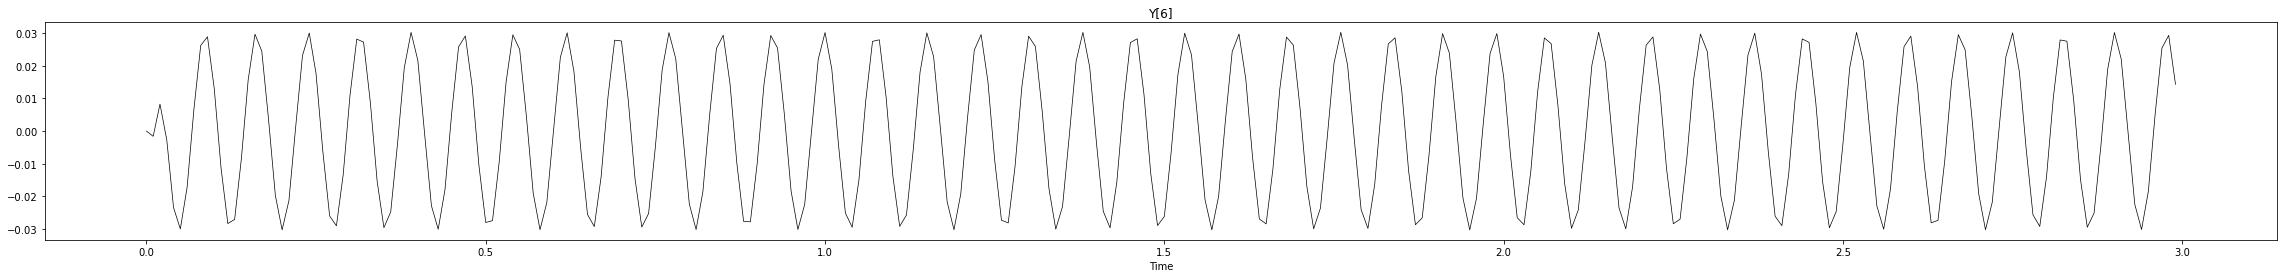

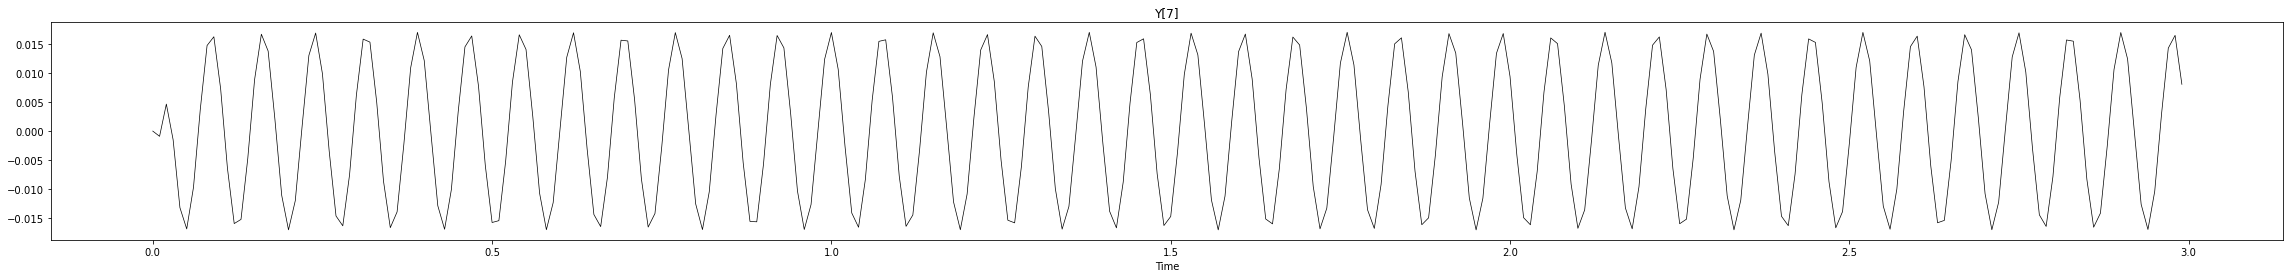

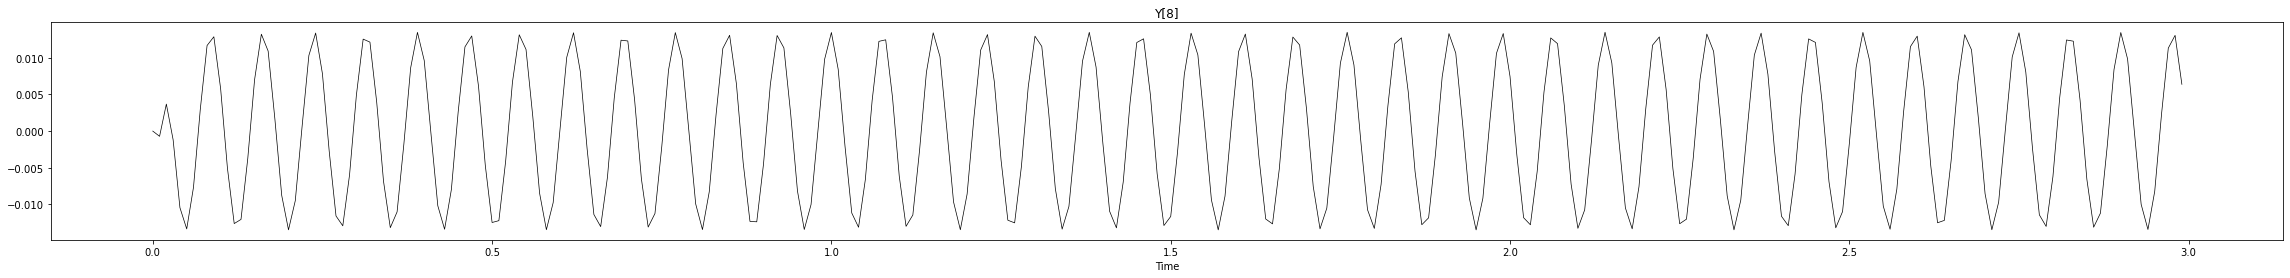

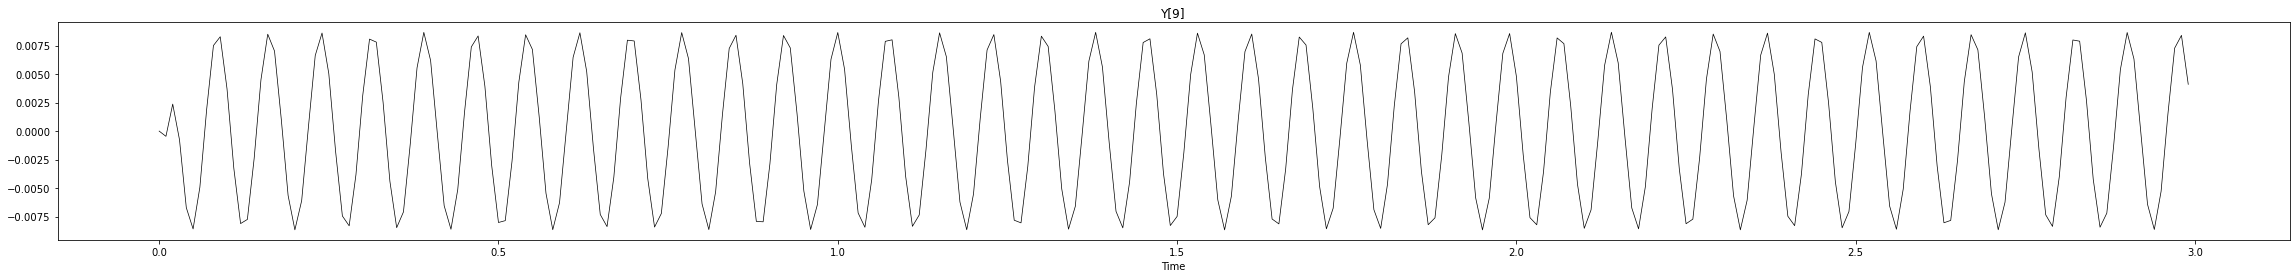

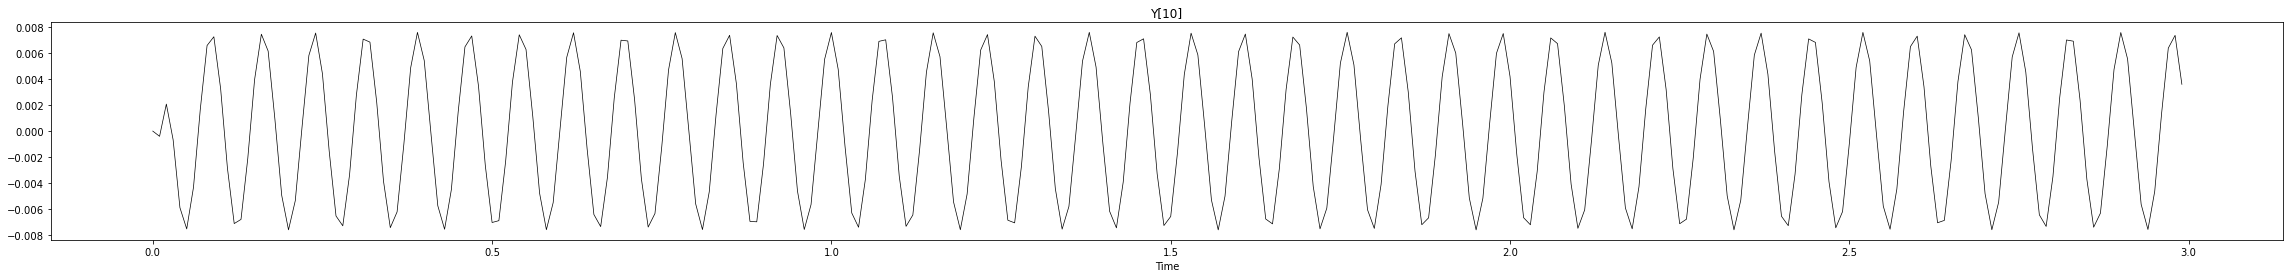

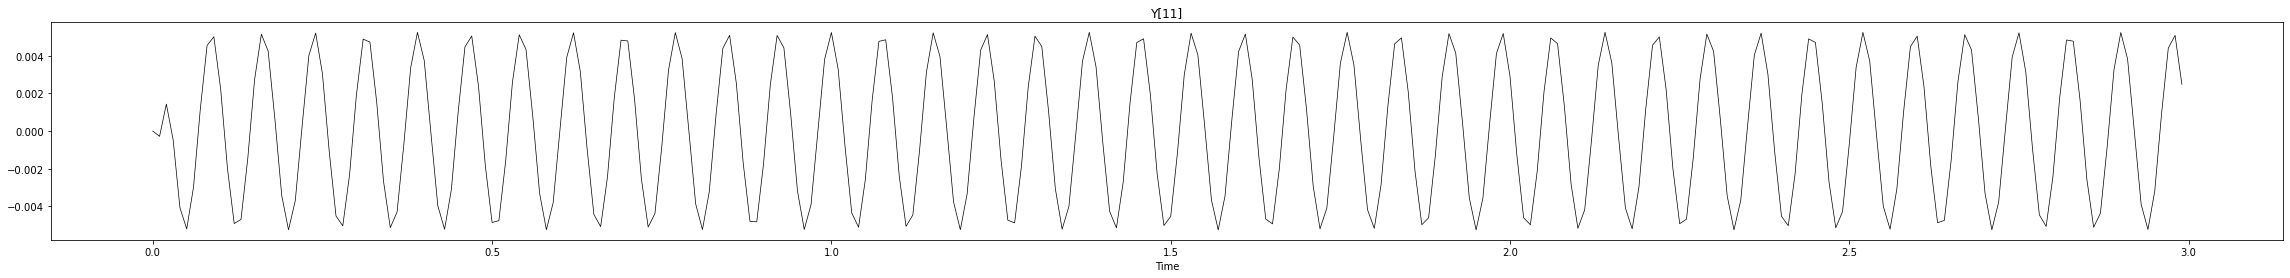

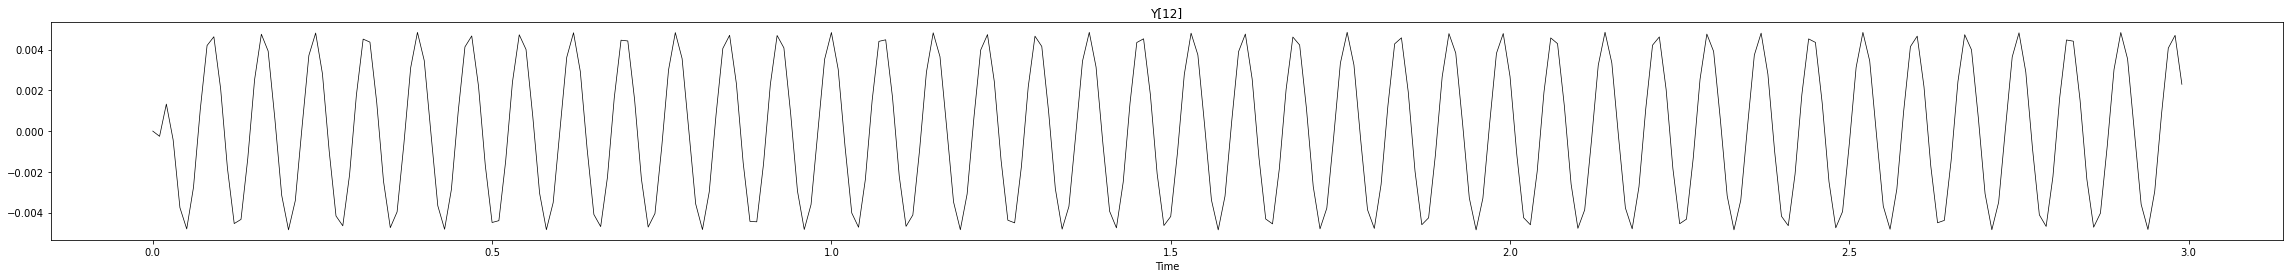

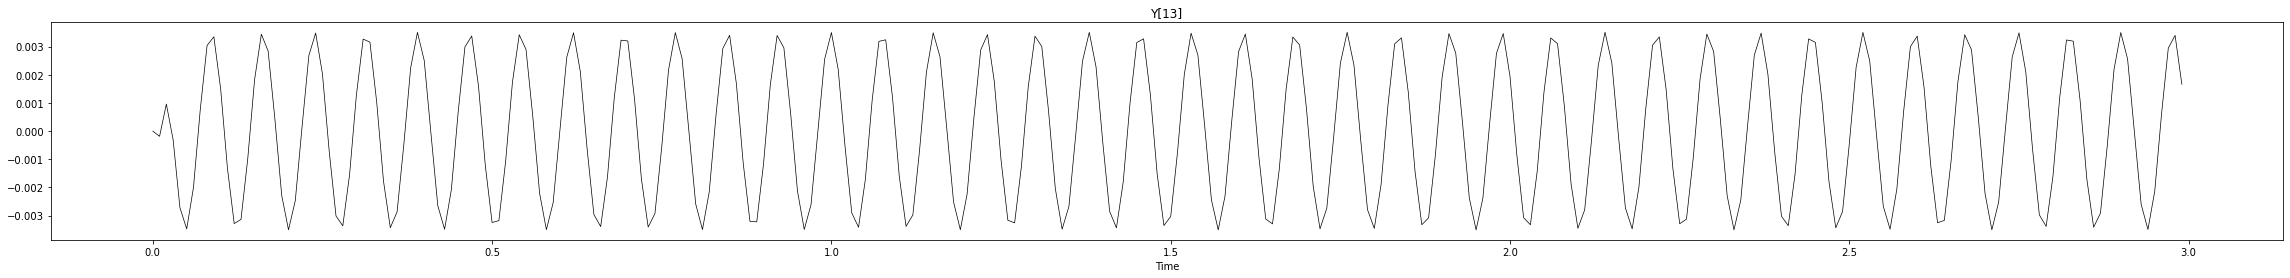

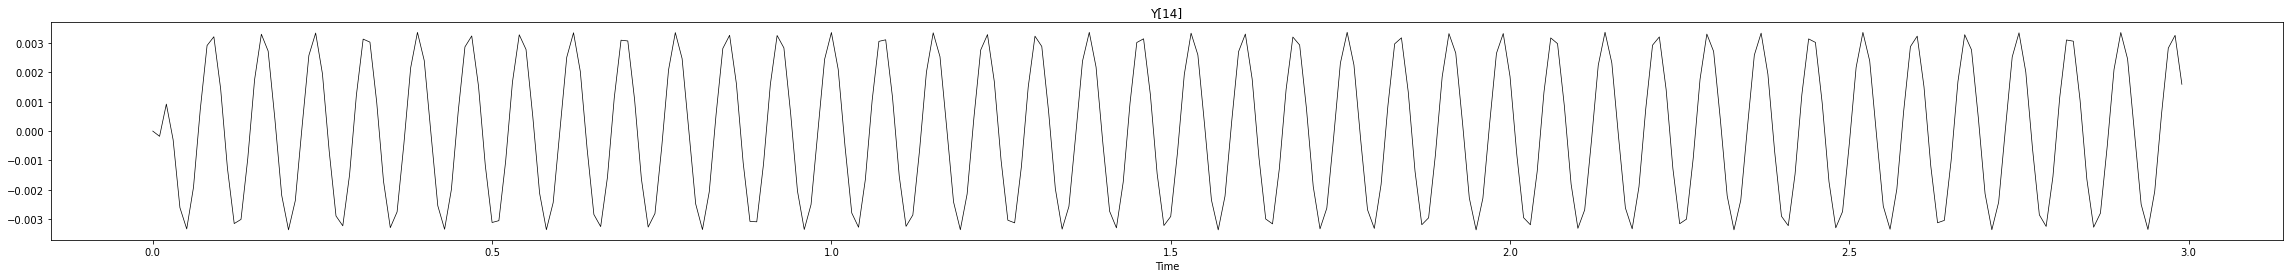

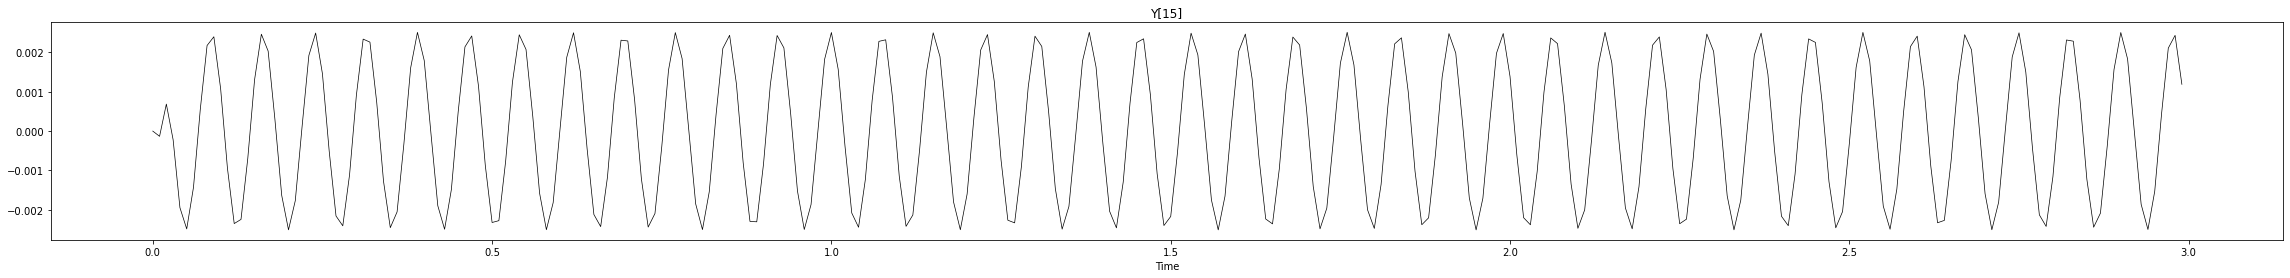

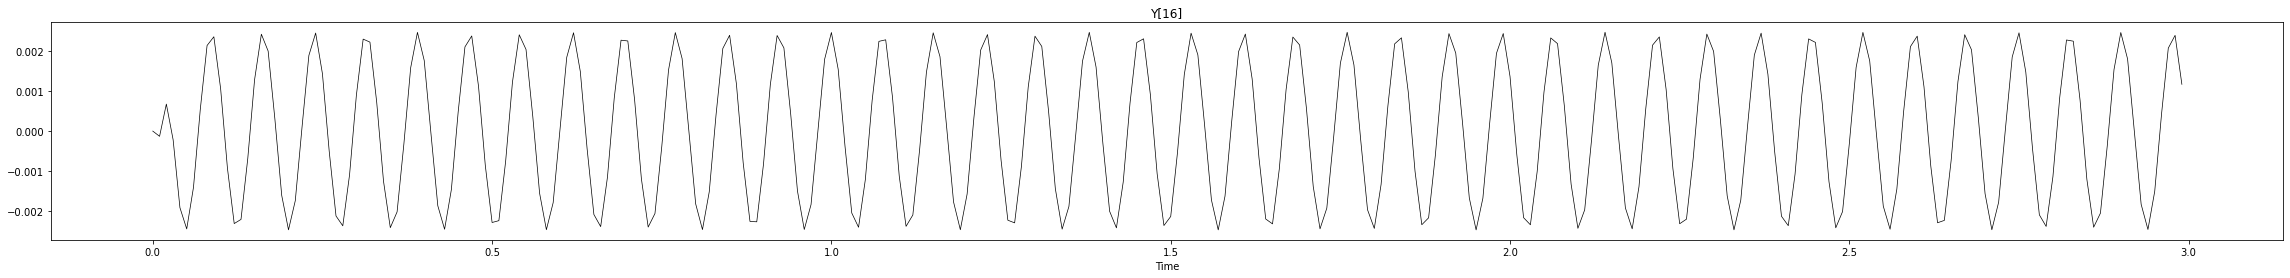

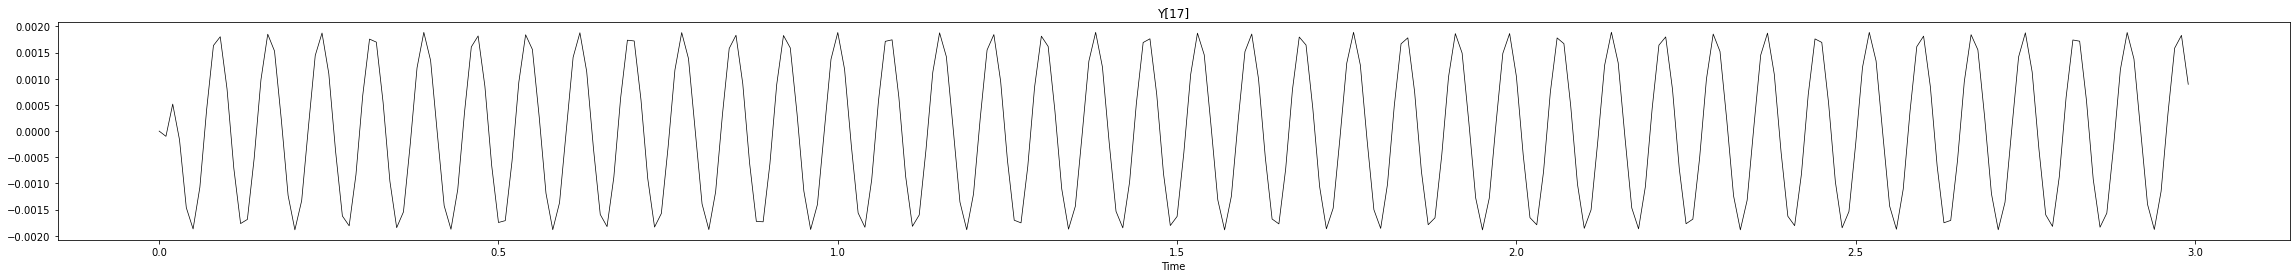

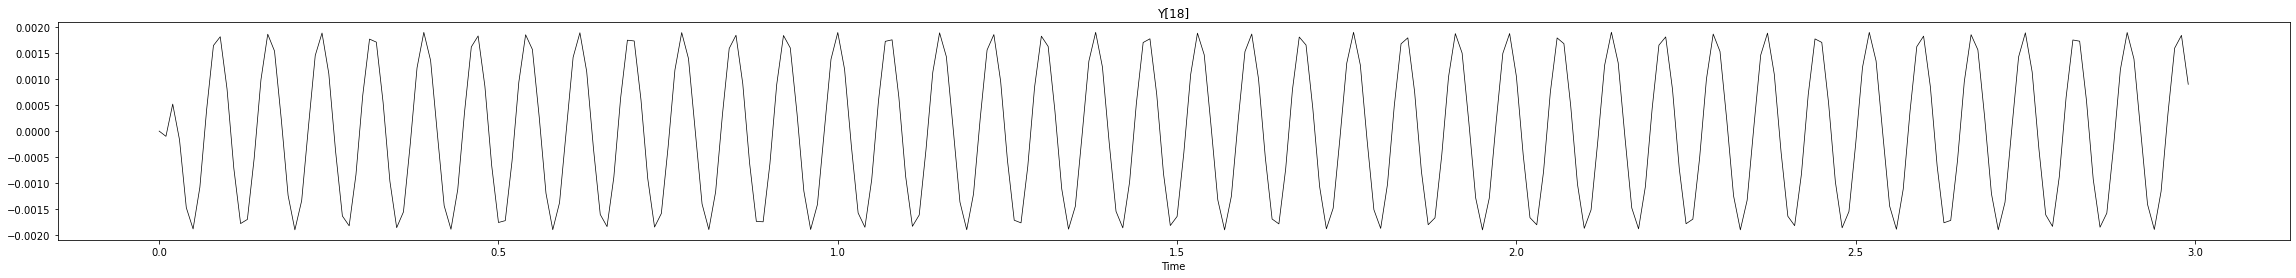

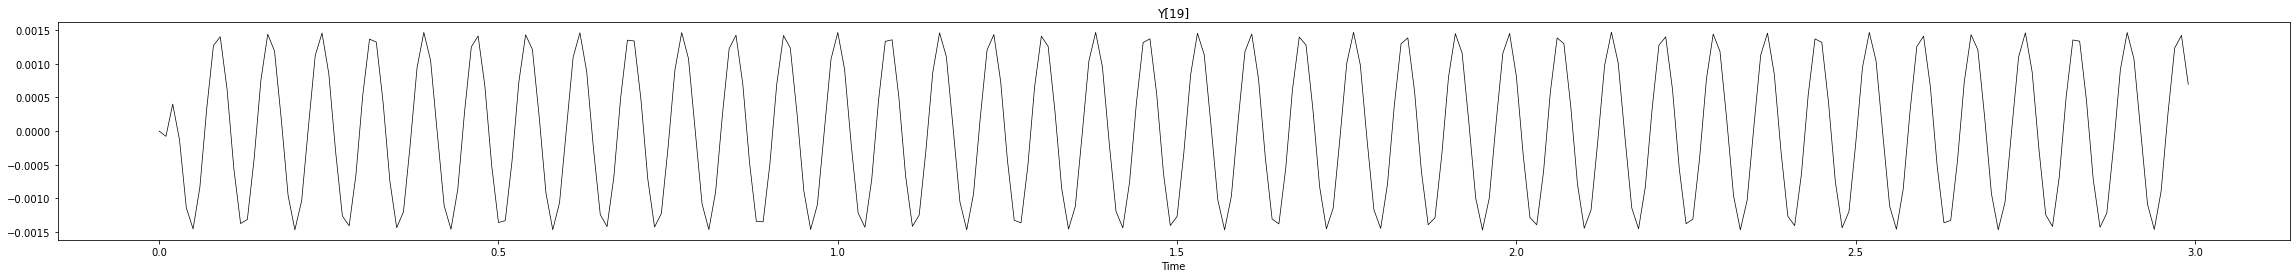

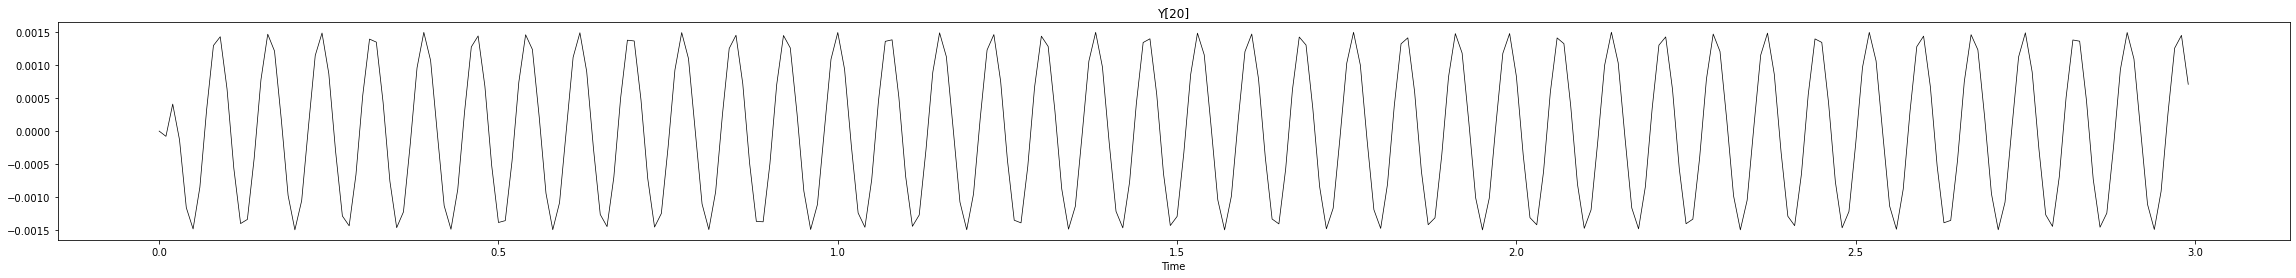

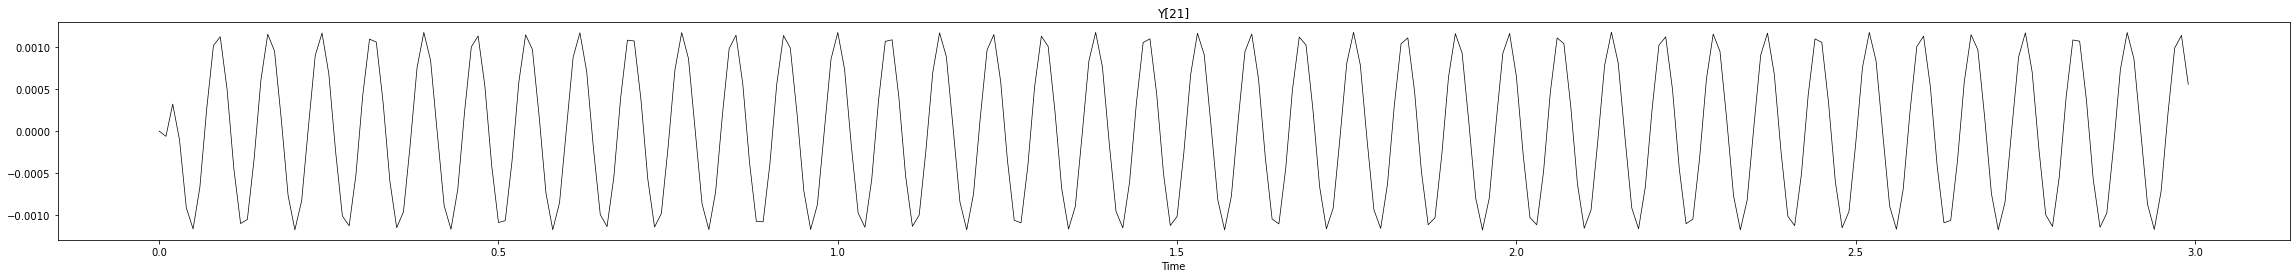

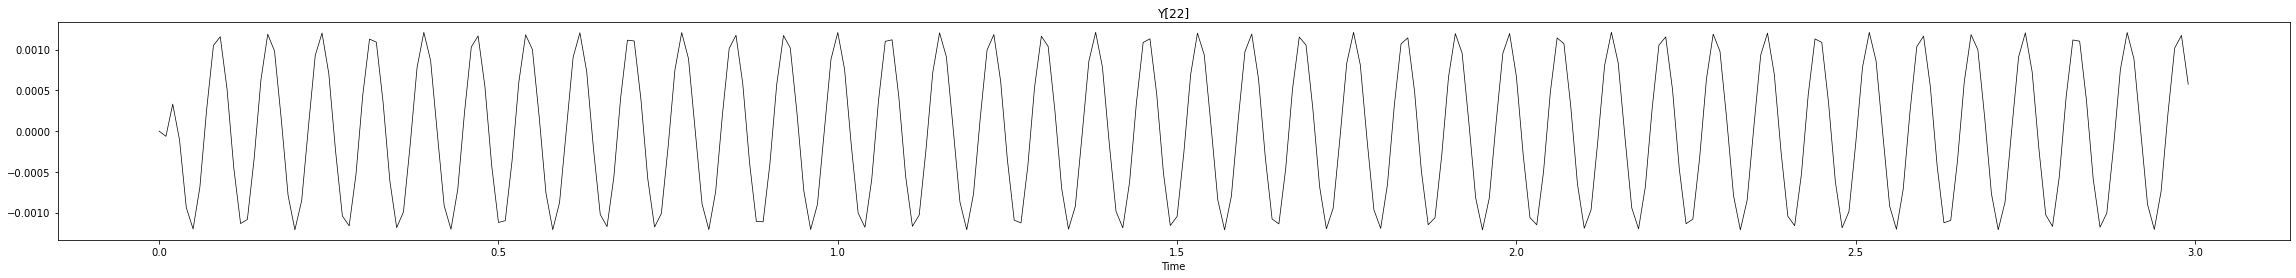

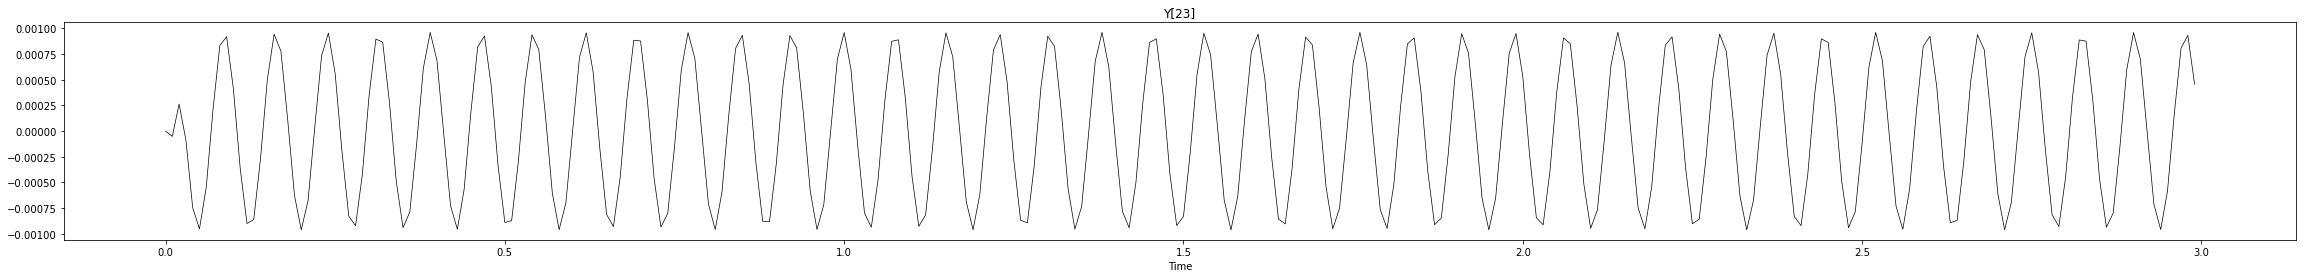

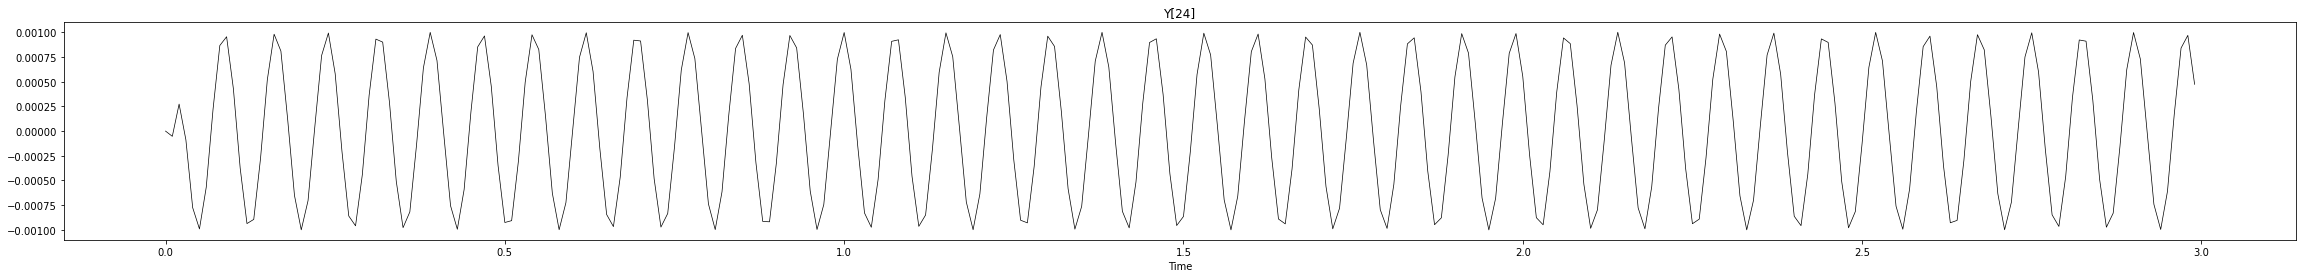

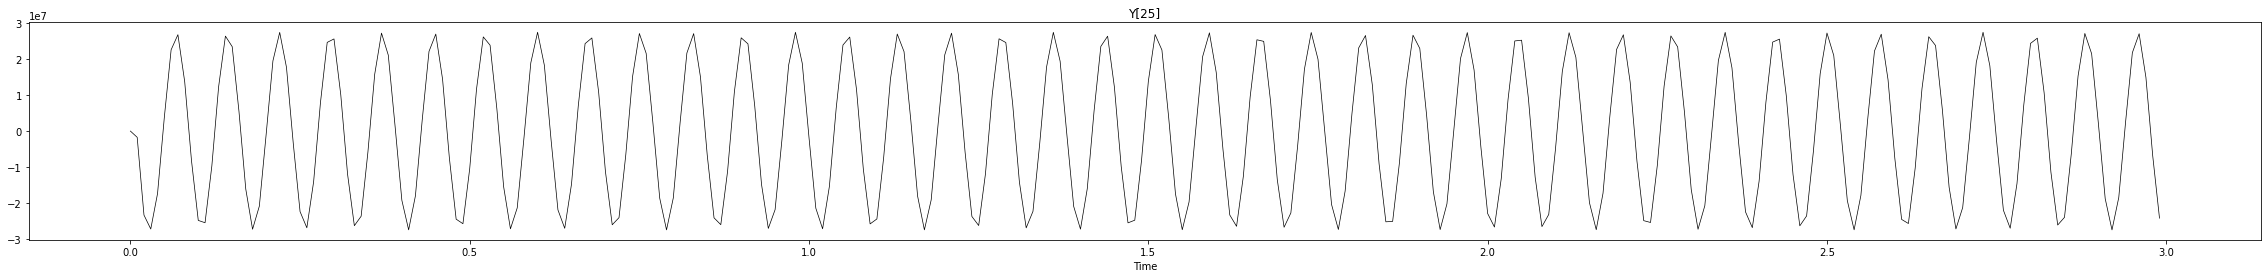

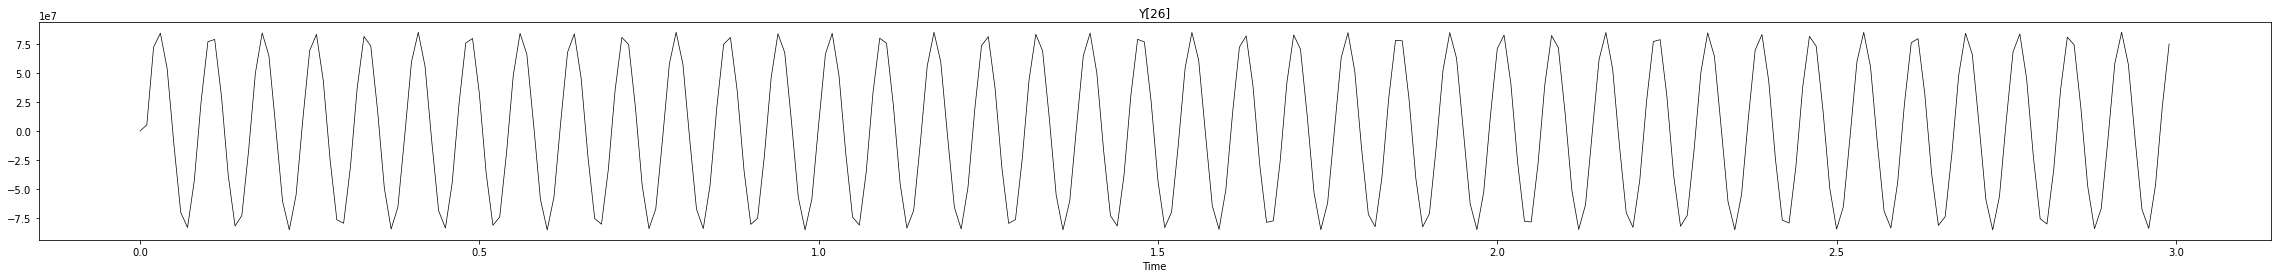

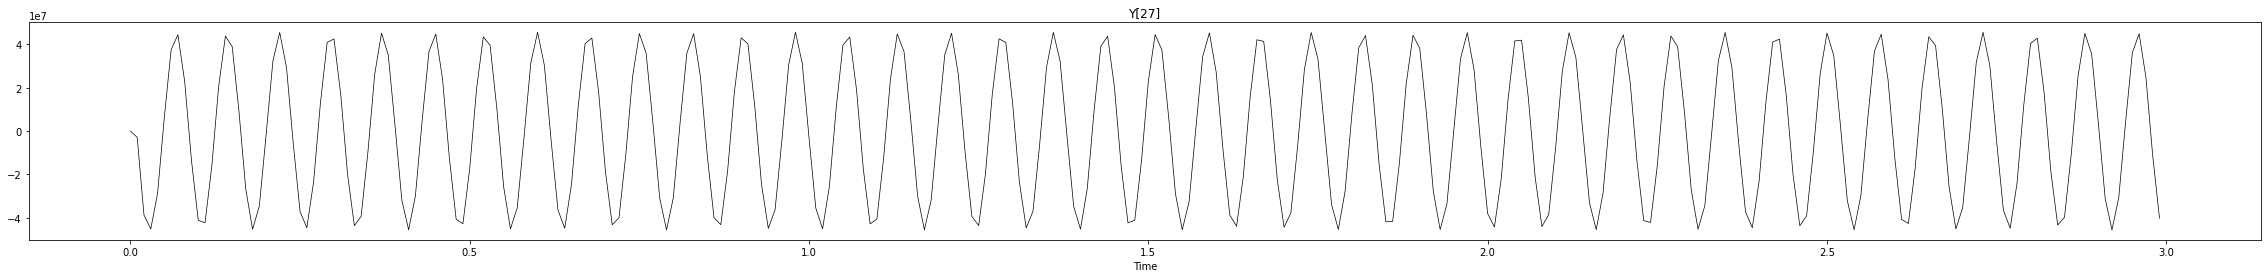

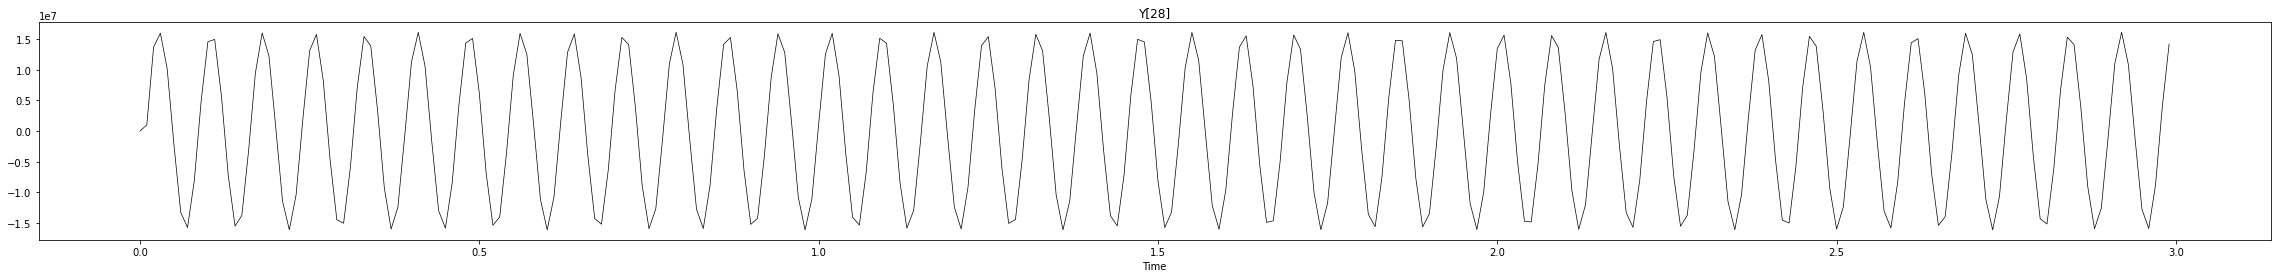

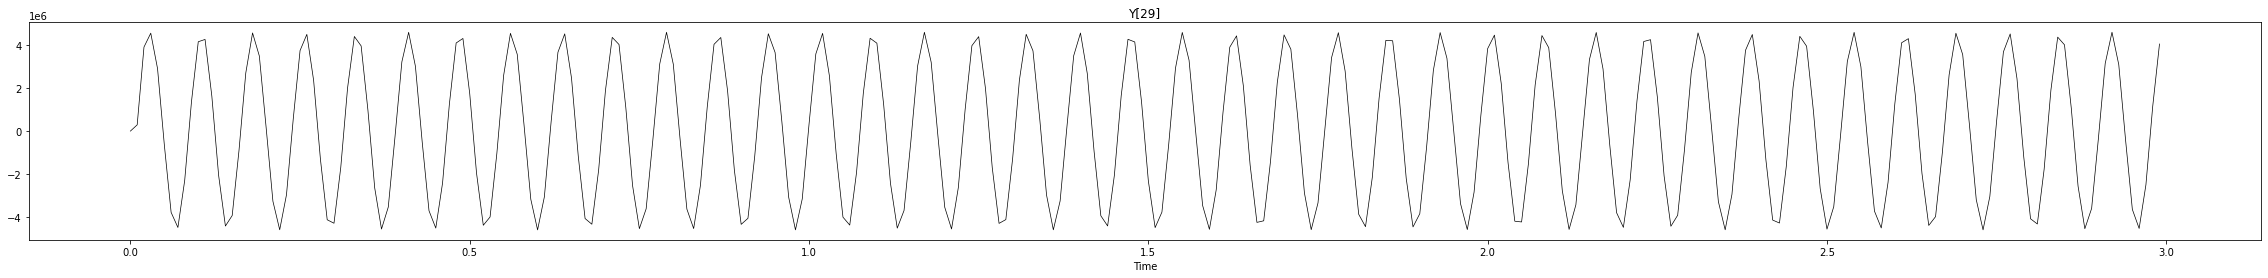

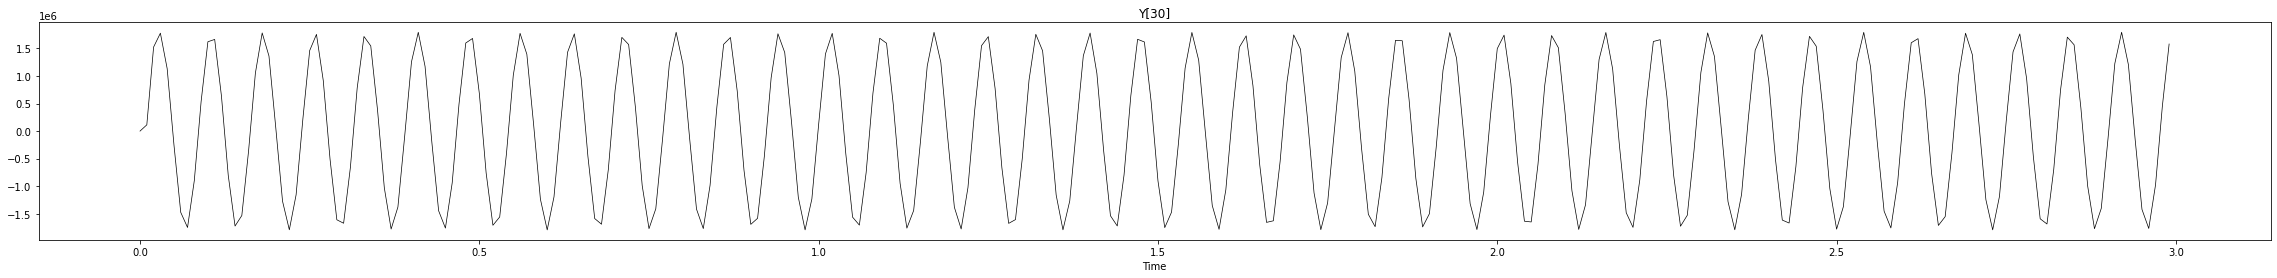

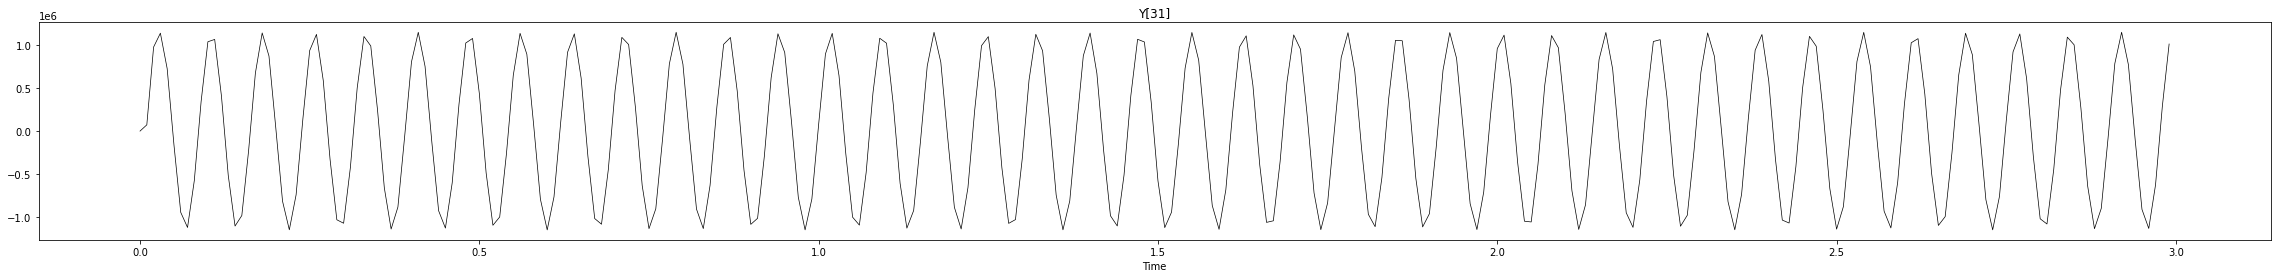

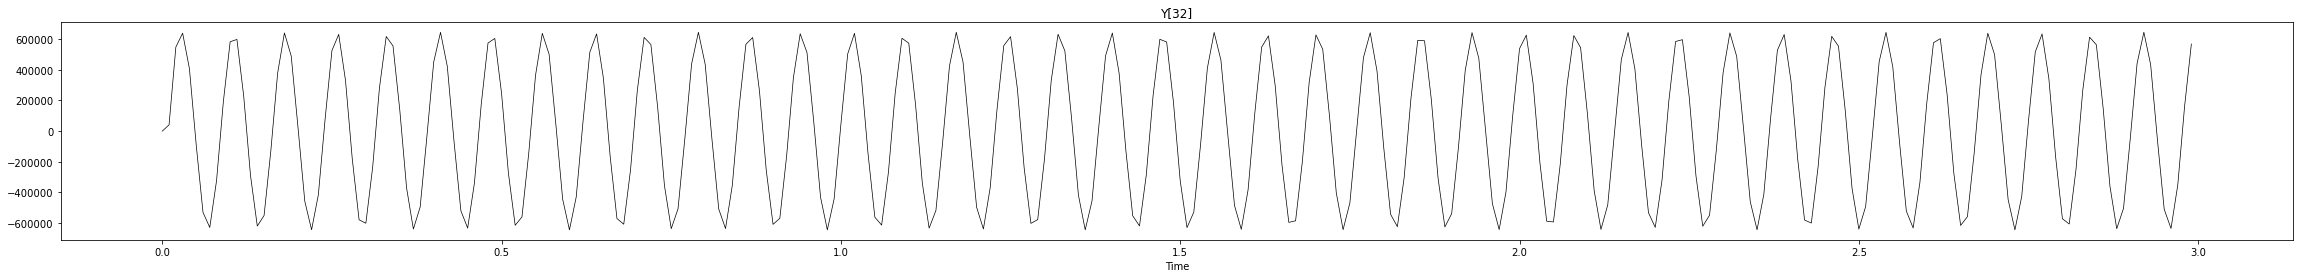

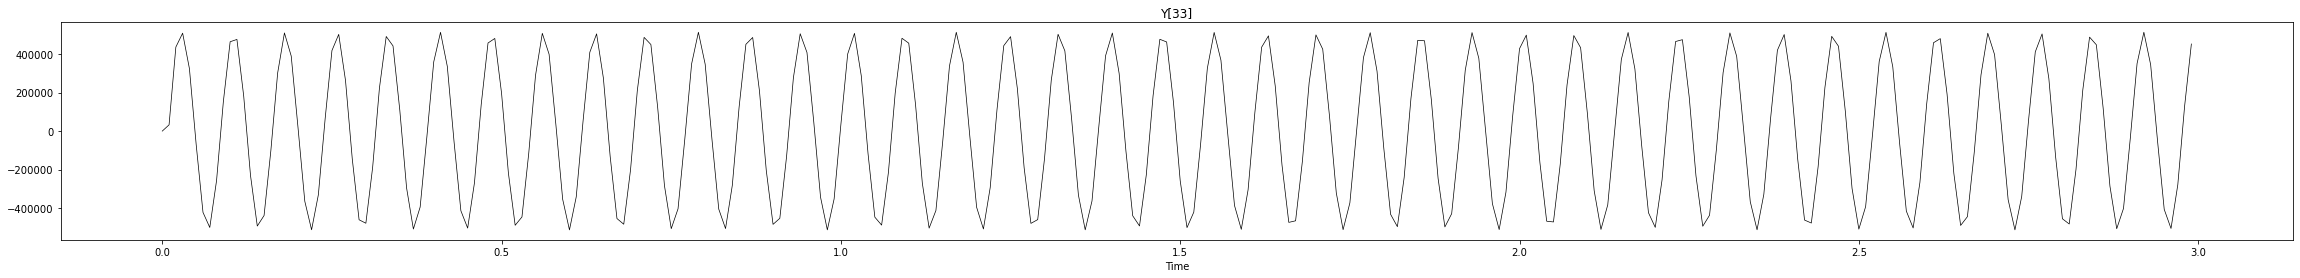

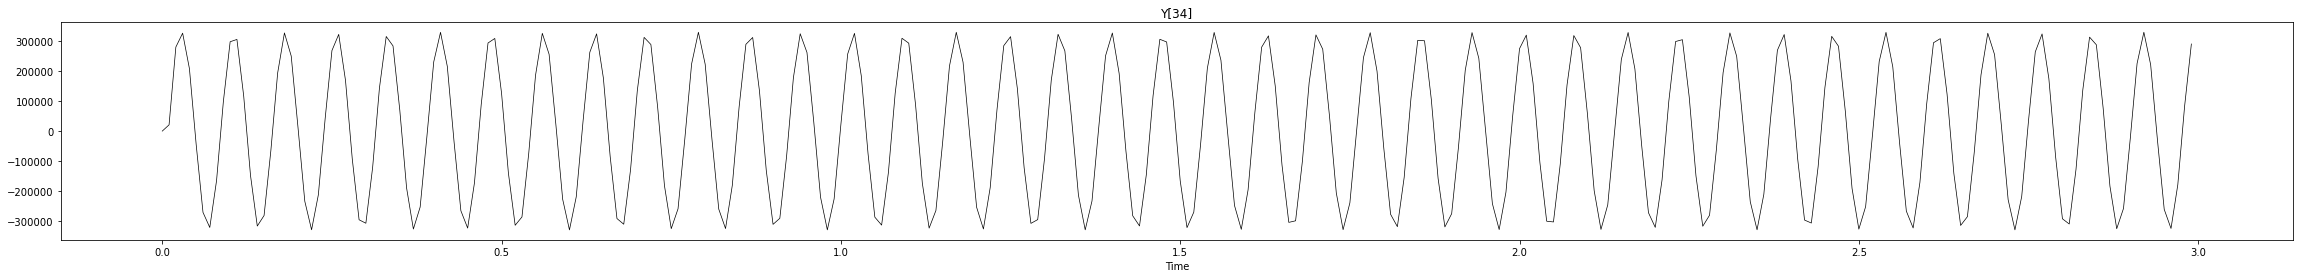

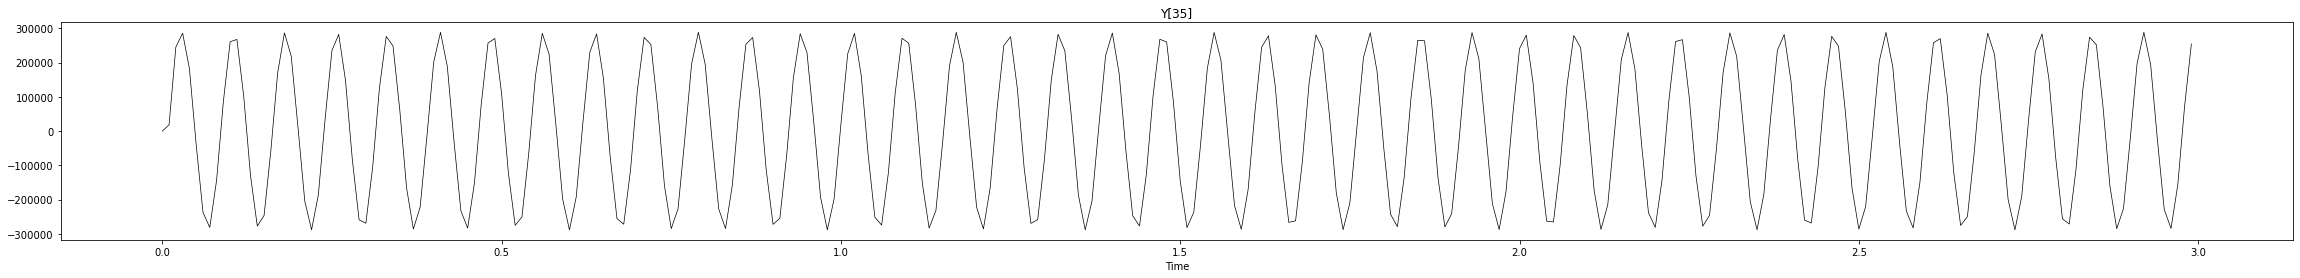

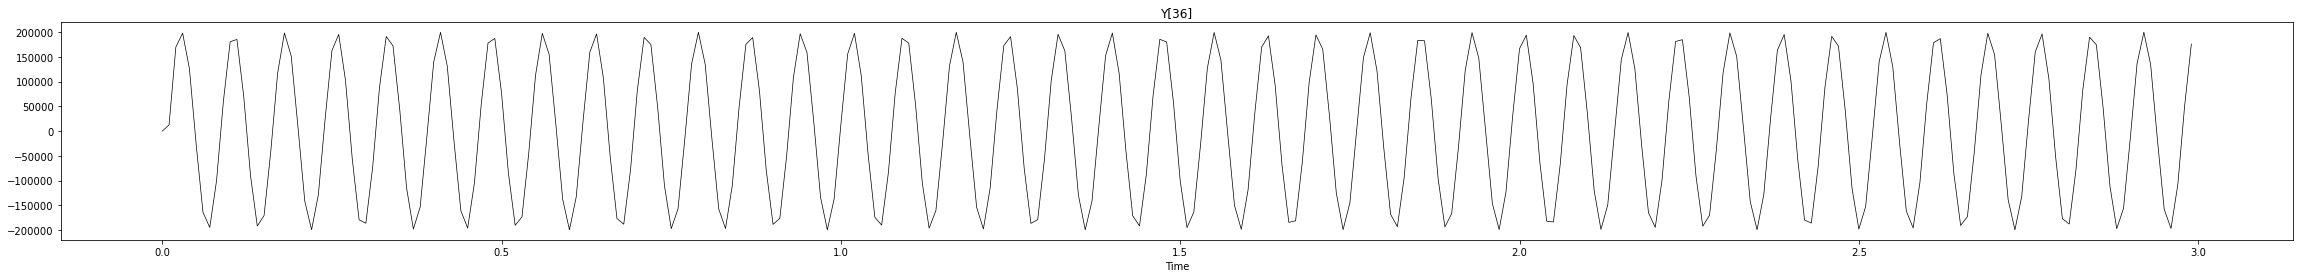

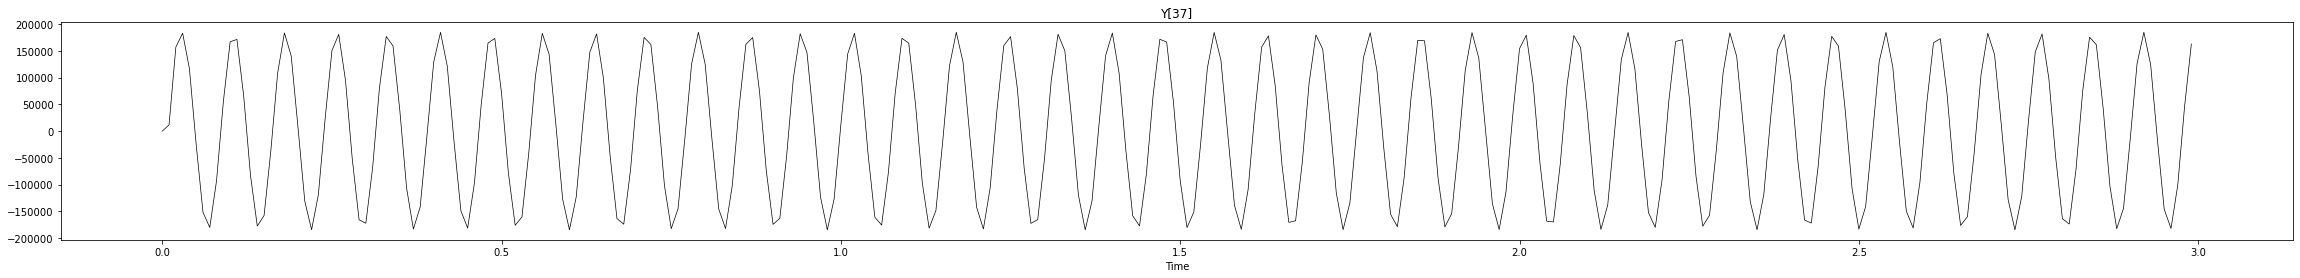

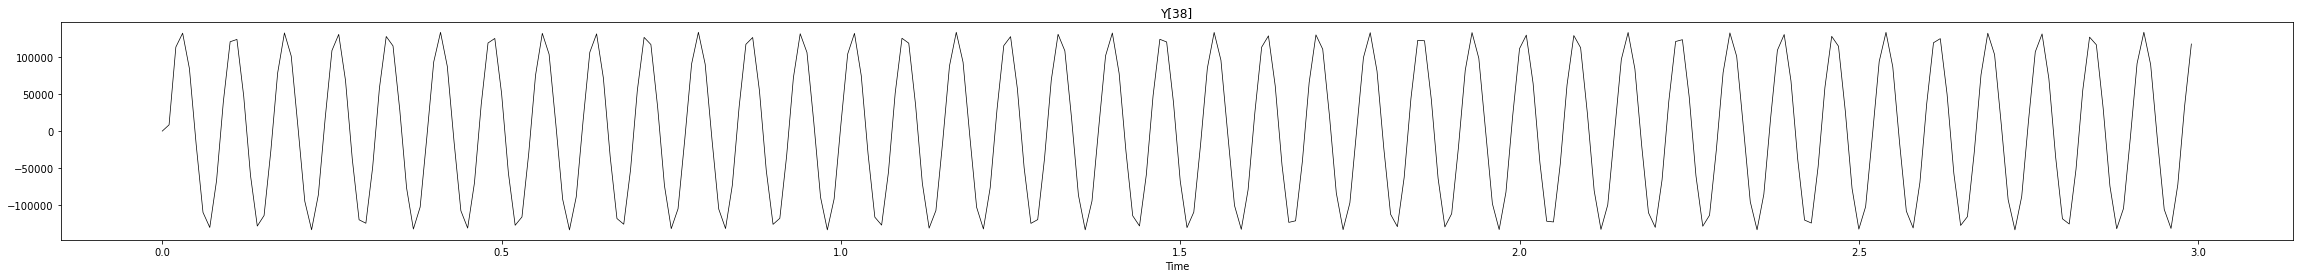

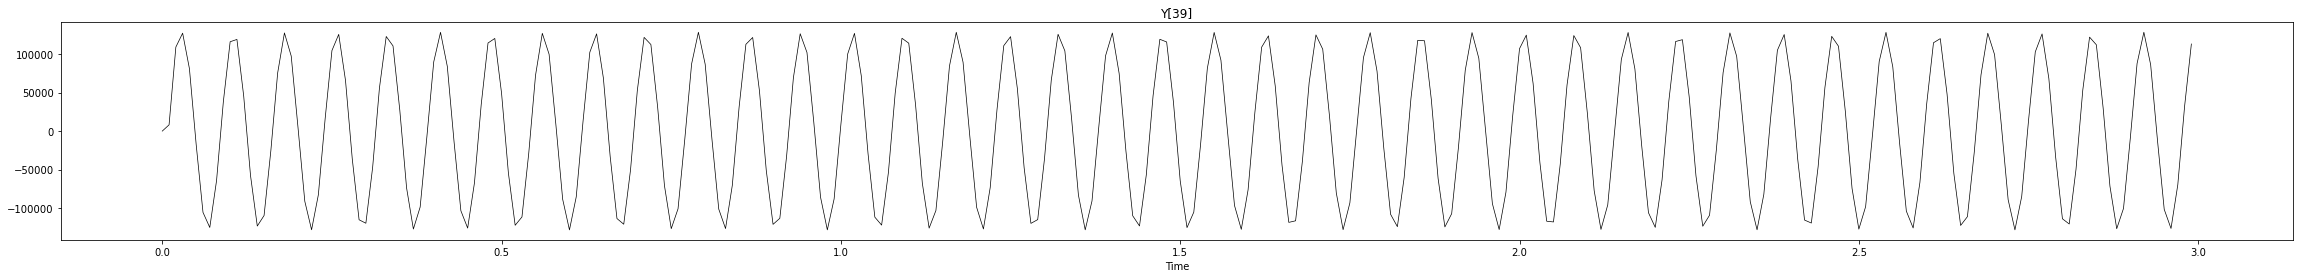

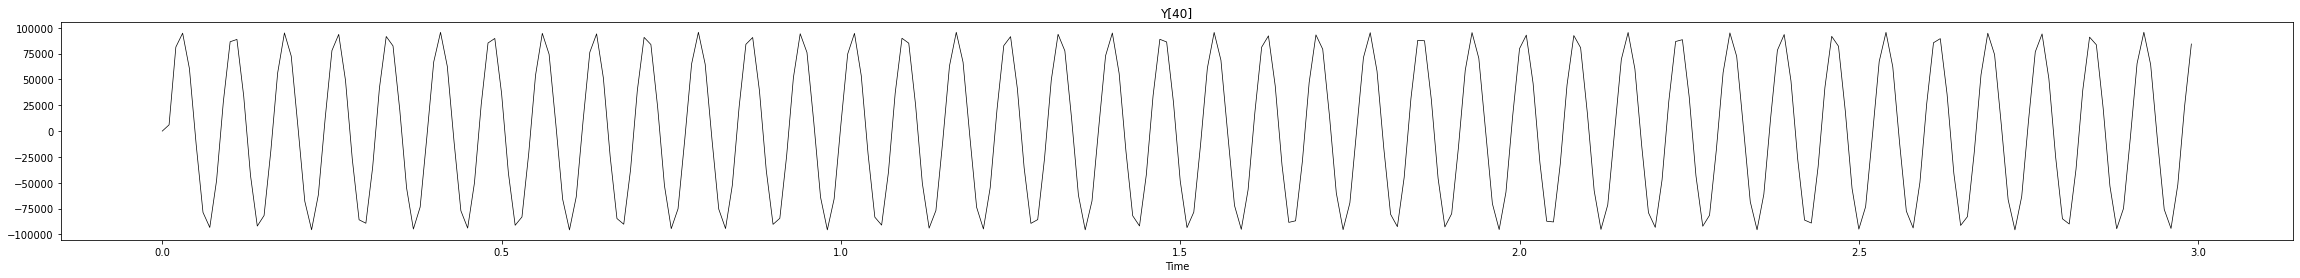

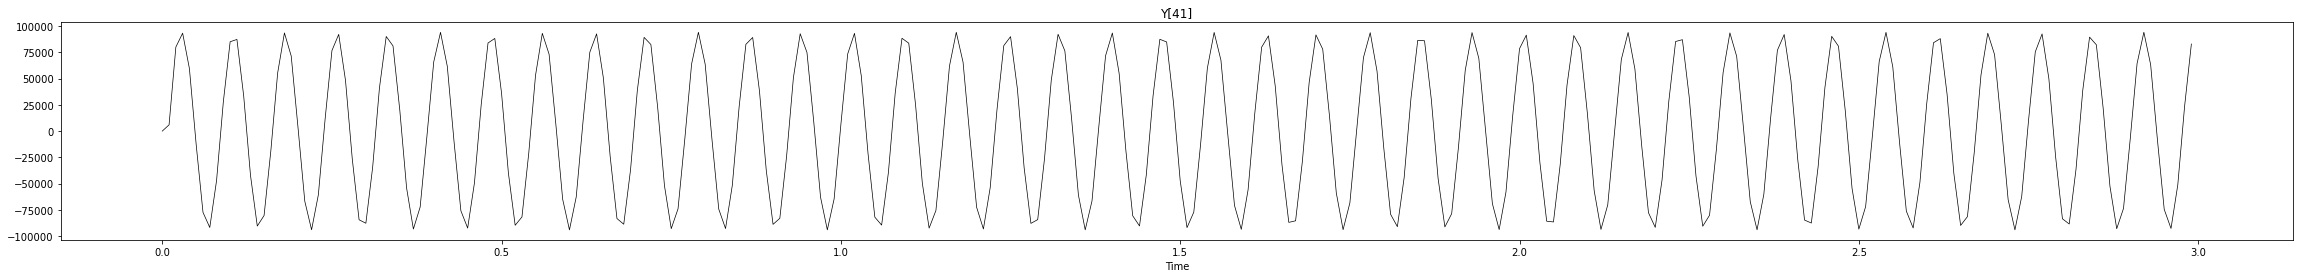

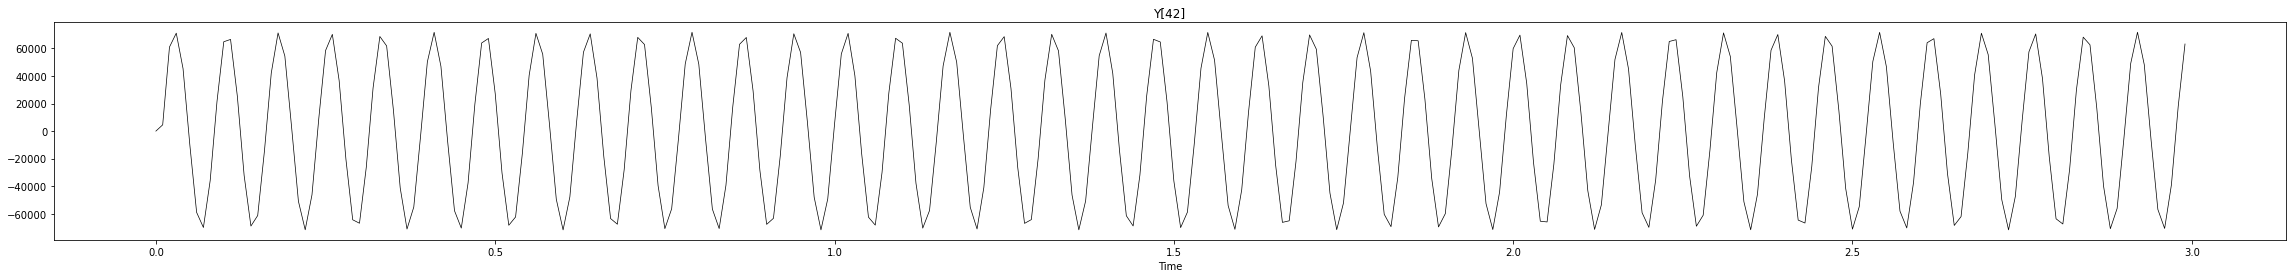

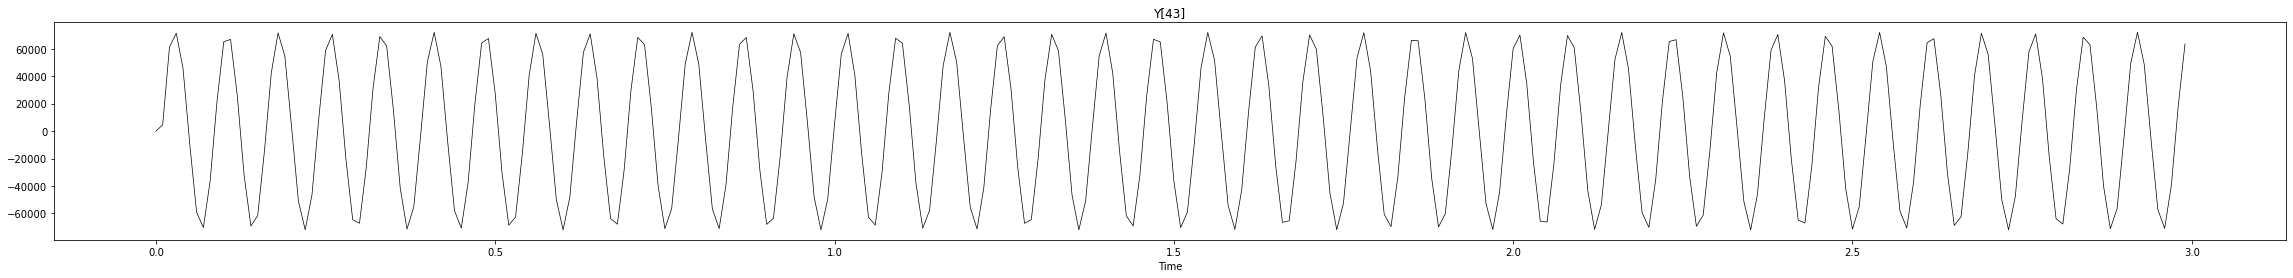

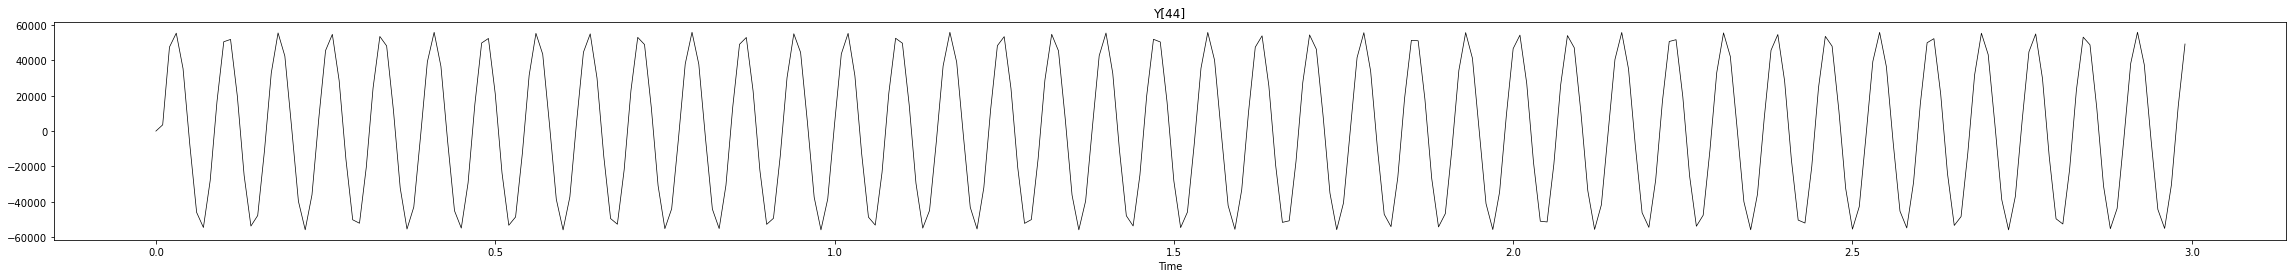

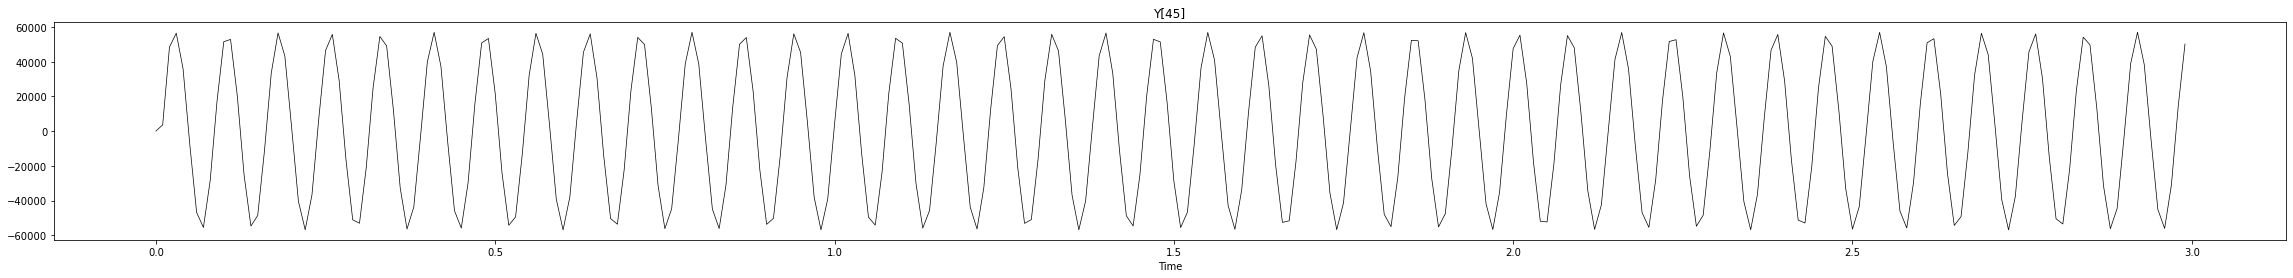

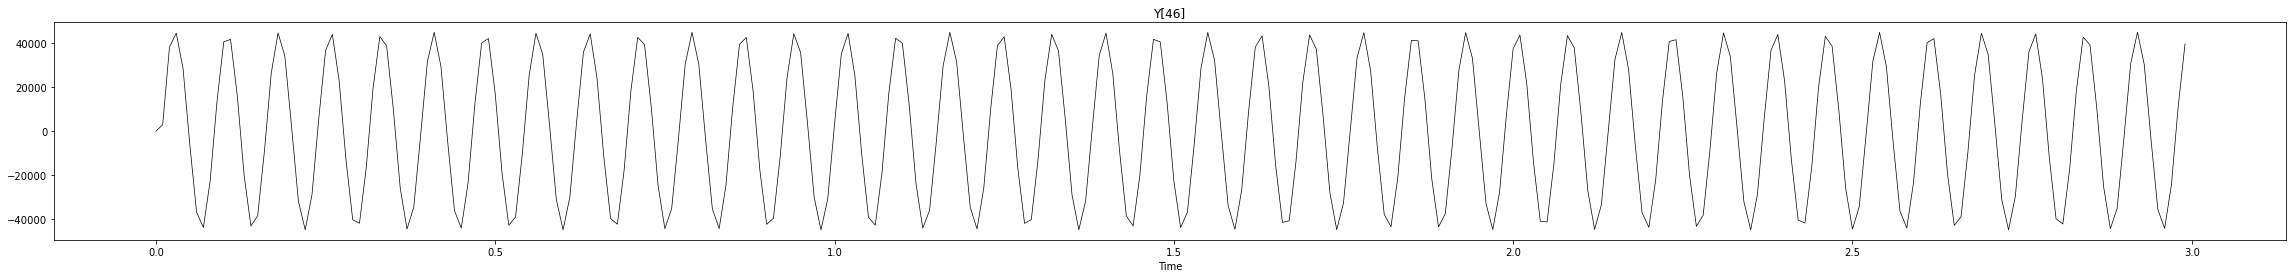

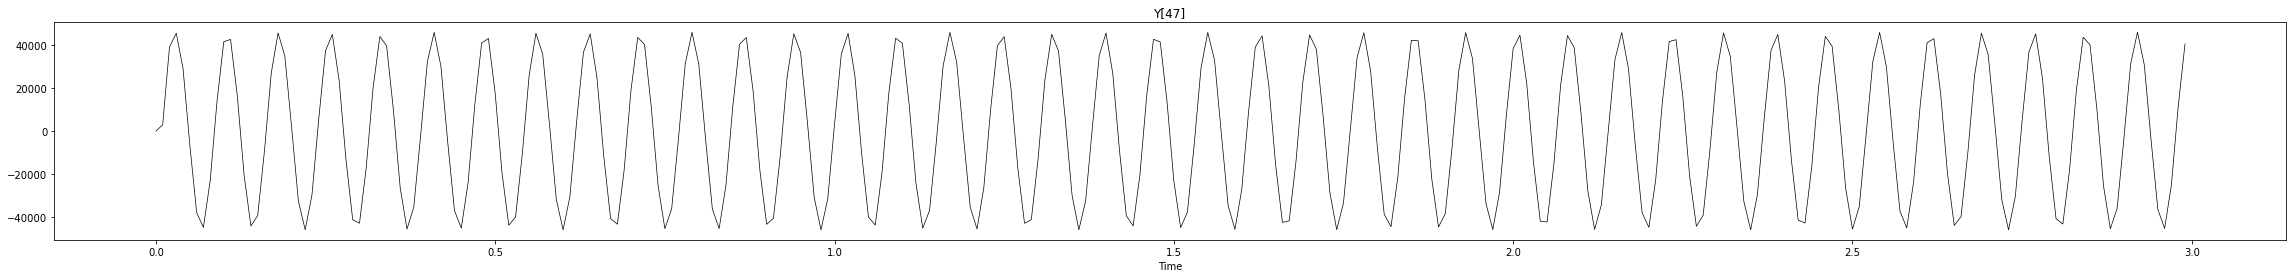

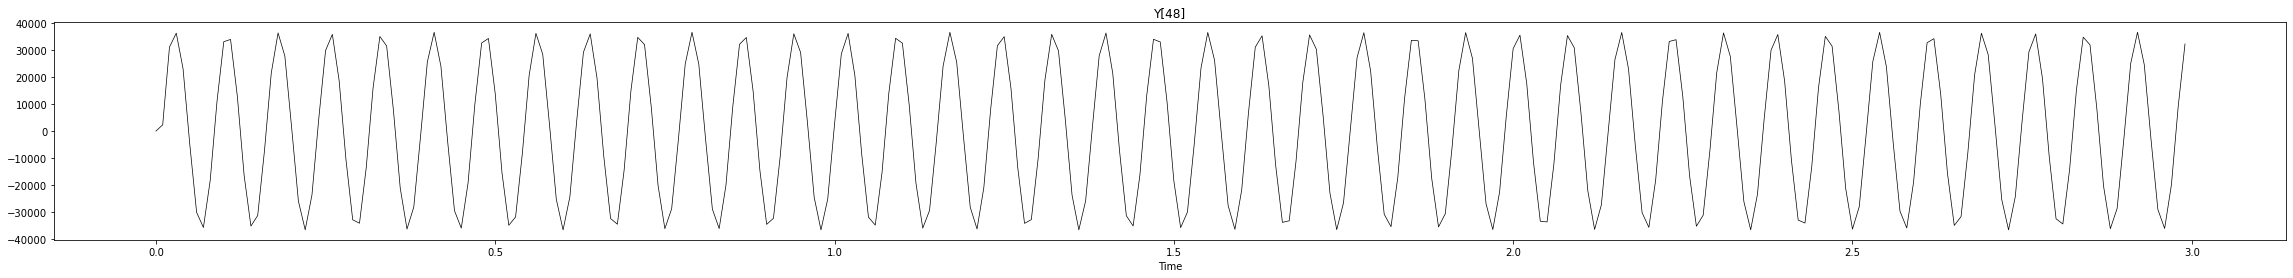

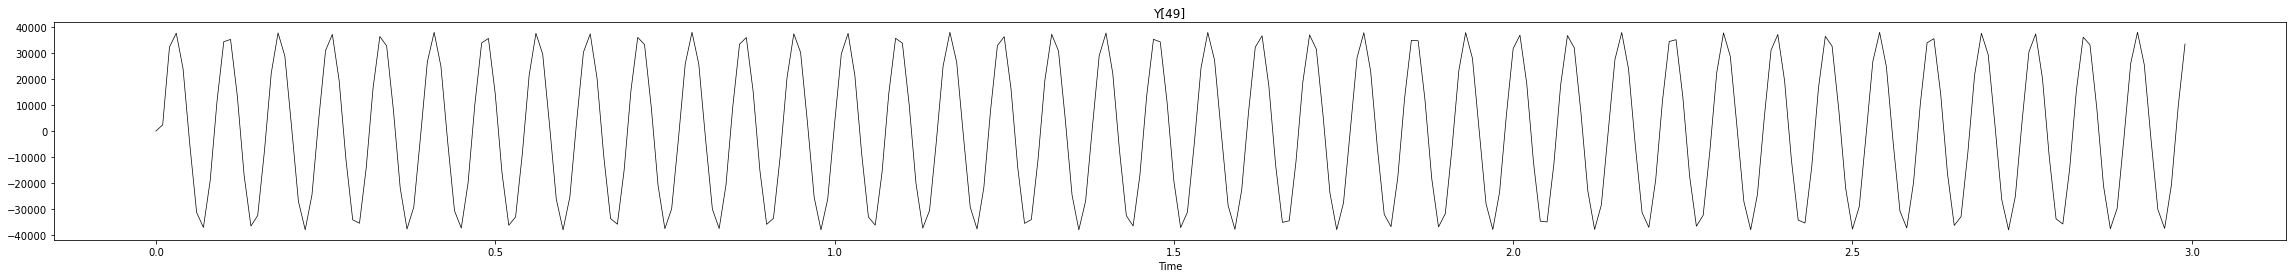

In [ ]:
for i in range(len(Y)):
    plt.figure(figsize=(40, 4))
    plt.plot(T, Y[i], linewidth = 0.7, color = 'black')
    plt.title('Y['+ str(i)+']')
    plt.xlabel('Time')
    plt.show() 